# Plotting the 'Stop Acquisition' Graphs

In [1]:
# Choose the dataset from 'ihdp' or 'acic2016'
dataset = 'ihdp'

# For the 'acic2016' datset, choose rho_TE from 0.3 or 0.7
rho_TE = 0.7

# Choose the desired threshold variable
threshold_variable = "TE"

In [2]:
import wandb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize W&B API
api = wandb.Api()

# Replace with your entity and project name
ENTITY = 'USERNAME' # change to your username
PROJECT = 'AFA4CATE_FINAL' # e.g., 'experiment_project'

# Fetch all runs in the project
runs = api.runs(f"{ENTITY}/{PROJECT}")

# Initialize a list to store run data
data = []

i=0
for run in runs:
    if (run.config["experiment_name"] != f"{dataset}_acquisition_stop"
        or (dataset == 'acic2016' and run.config['rho_TE'] != rho_TE)
        or run.config['acquisition_metric'] not in ["r_PO", "r_TE", "random", "r_sTE"]
        or run.config['threshold_variable'] != threshold_variable):
            continue
    i += 1
    # Extract summary metrics
    summary = run.summary
    
    # Extract config parameters if needed
    config = run.config
    
    # Ensure the required fields are present
    required_fields = ["total_score",
                       "total_cost", "number_predict", "number_withhold",
                       "average_cost_for_withhold",
                       "average_cost_for_predict",
                       "total_score_per_cost"]
    if not all(field in summary for field in required_fields):
        print(run.name)
        continue  # Skip runs that don't have all required fields
    
    percentile_var_threshold = config["percentile_var_threshold"]
    total_score = summary["total_score"]
    total_cost = summary["total_cost"]
    number_predict = summary["number_predict"]
    number_withhold = summary["number_withhold"]
    average_cost_for_withhold = summary["average_cost_for_withhold"]
    average_cost_for_predict = summary["average_cost_for_predict"]
    pehe_for_predict = summary["pehe_for_predict"] if "pehe_for_predict" in summary else np.nan
    pehe_for_withhold = summary["pehe_for_withhold"] if "pehe_for_withhold" in summary else np.nan
    total_score_per_cost = summary["total_score_per_cost"]
    acquisition_metric = config["acquisition_metric"]
    seed = config["seed"]
    
    # Append the data
    data.append({
        "percentile_var_threshold": percentile_var_threshold,
        "total_score": total_score,
        "total_cost": total_cost,
        "number_predict": number_predict,
        "number_withhold": number_withhold,
        "average_cost_for_withhold": average_cost_for_withhold,
        "average_cost_for_predict": average_cost_for_predict,
        "pehe_for_predict": pehe_for_predict,
        "pehe_for_withhold": pehe_for_withhold,
        "total_score_per_cost": total_score_per_cost,
        "acquisition_metric": acquisition_metric,
        "seed": seed,
    })

# Create a DataFrame
df = pd.DataFrame(data)
df.replace("NaN", np.nan, inplace=True)

assert i == 280, "Number of runs is not correct (given that 10 seeds were used)"
assert len(df) == 280, "Number of runs is not correct (given that 10 seeds were used)"

/tmp/ipykernel_206750/1511098490.py:75: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace("NaN", np.nan, inplace=True)


In [4]:
# verify that the correct number of runs has been loaded -- for 10 seeds, each acquisition function should have 70 runs
df.acquisition_metric.value_counts()

acquisition_metric
random    70
r_PO      70
r_TE      70
r_sTE     70
Name: count, dtype: int64

In [5]:
df.isna().sum()

percentile_var_threshold      0
total_score                   0
total_cost                    0
number_predict                0
number_withhold               0
average_cost_for_withhold    48
average_cost_for_predict      3
pehe_for_predict              3
pehe_for_withhold            48
total_score_per_cost          0
acquisition_metric            0
seed                          0
dtype: int64

In [6]:
df.head()

,percentile_var_threshold,total_score,total_cost,number_predict,number_withhold,average_cost_for_withhold,average_cost_for_predict,pehe_for_predict,pehe_for_withhold,total_score_per_cost,acquisition_metric,seed
0,0.99,24,463,30,0,NaN,15.433333,0.086283,NaN,0.051836,random,2
1,0.99,21,344,29,1,8.0,11.586207,0.055588,0.036189,0.061047,random,3
2,0.99,22,347,30,0,NaN,11.566667,0.062711,NaN,0.063401,random,4
3,0.99,22,328,30,0,NaN,10.933333,0.075740,NaN,0.067073,random,5
4,0.99,28,270,30,0,NaN,9.000000,0.070990,NaN,0.103704,random,6


In [7]:
# calculating the average score (per 30 individuals in the test sample)
df['average_score'] = df['total_score'] / 30
df['average_score_per_cost'] = df['total_score_per_cost'] / 30

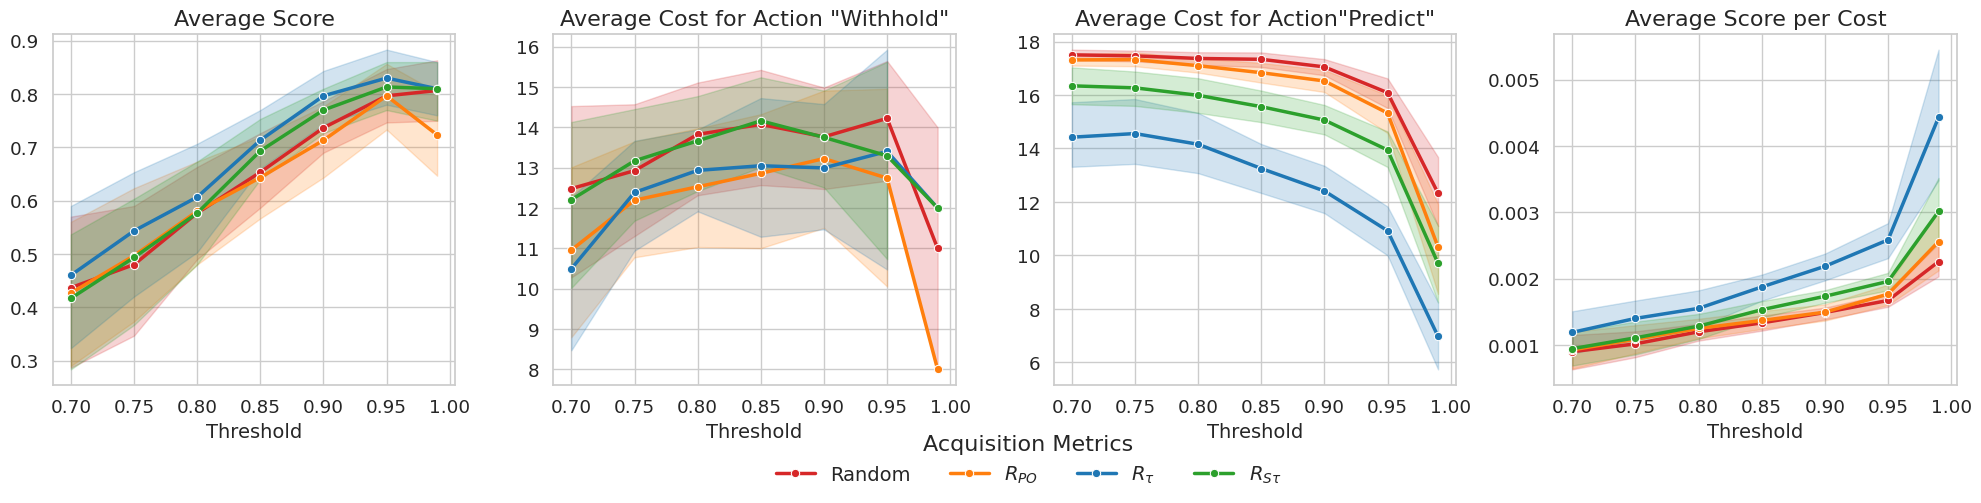

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

df_plot = df.copy()
# Assuming df_clean is your cleaned DataFrame
# and aggregated_df is already defined as per your provided code

# Define the metrics to plot and their labels
plot_metrics = [
    ('average_score', 'Average Score'),
    ('average_cost_for_withhold', 'Average Cost for Action "Withhold"'),
    ('average_cost_for_predict', 'Average Cost for Action"Predict"'),
    ('average_score_per_cost', 'Average Score per Cost')
]
nice_names = {"r_TE": r"$R_\tau$", "r_PO": r"$R_{PO}$", "r_sTE": r"$R_{S\tau}$", "random": "Random", "neg_r_TE_plus_var": r"$R_{\tau\delta}$"}
df_plot['metric_label'] = df_plot['acquisition_metric'].map(nice_names)

sns.set(style="whitegrid", context="notebook", font_scale=1.2)

# Define a color palette based on the number of unique acquisition metrics
palette = sns.color_palette("tab10", n_colors=df_plot['acquisition_metric'].nunique())
palette_dict = {r"$R_\tau$": palette[0], r"$R_{PO}$": palette[1], r"$R_{S\tau}$": palette[2], "Random": palette[3]}

# Create a color mapping dictionary
color_mapping = dict(zip(df_plot['metric_label'].unique(), palette))

# Initialize the figure with 4 subplots in a single row
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharex=True)

for ax, (metric, label) in zip(axes, plot_metrics):
    # Plot the average metric line
    sns.lineplot(
        data=df_plot,
        x="percentile_var_threshold",
        y=metric,
        hue="metric_label",
        marker="o",
        errorbar=('ci', 90),
        ax=ax,
        palette=palette_dict,
        linewidth=2.5
    )

    # Set subplot title and labels
    ax.set_title(label, fontsize=16)
    ax.set_xlabel("Threshold", fontsize=14)
    ax.set_ylabel("", fontsize=12)

# Adjust layout to accommodate the legend and titles
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Create a single legend for all subplots
handles, labels = axes[0].get_legend_handles_labels()
# Create the legend outside the grid
fig.legend(
    handles,
    labels,
    loc='lower center',
    ncol=len(labels),
    fontsize=14,
    title='Acquisition Metrics',
    title_fontsize=16,
    frameon=False,
    bbox_to_anchor=(0.52, -0.08)  # Adjust y-coordinate based on your layout
)

# Remove individual legends from subplots
for ax in axes:
    ax.get_legend().remove()

# Set an overall title for the figure
# fig.suptitle("Metrics vs Percentile Var Threshold by Acquisition Metric", fontsize=16, y=0.98)

# Save the figure (optional)
plt.savefig(f"{dataset}_{f'rho_TE_{rho_TE}' if dataset == 'acic2016' else ''}_stop_acquisition_threshold_{threshold_variable}.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()
